### 1. Theory Questions:
**• Q1: Why is the KL Divergence term important in the VAE loss function?**

KL Divergence can egularize the latent space, so that the latent space can be smooth and continuous, and allowing meaningful data generation.

**• Q2: How does the reparameterization trick enable backpropagation through the stochastic layers of a VAE?**

It transforms the random sampling into z = 𝜇 + 𝜎.𝜖 where 𝜖 ∼ 𝑁 (0, 1). VAE can keep stochasticity while ensuring that gradients can flow back through the network for optimization during training.

**• Q3: Why does a VAE use a probabilistic latent space instead of a fixed latent space?**

It enables the generation of multiple, varied outputs from the same input by sampling different points from the latent space.

**• Q4: What role does KL Divergence play in ensuring a smooth latent space?**

It is a key component of loss function.


### 2. Coding Tasks

Task 1:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

Data loading and preprocessing

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 170M/170M [00:03<00:00, 43.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


Original Pytorch VAE

In [3]:
class VAE(nn.Module):
  def __init__(self, input_dim=3072, hidden_dim=512, latent_dim=128):
    super(VAE, self).__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.latent_dim = latent_dim

    # Encoder
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU()
    )

    # Latent space
    self.fc_mu = nn.Linear(hidden_dim, latent_dim)
    self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    # Decoder
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, input_dim),
        nn.Sigmoid()  # Output in [0, 1]
    )

  def encode(self, x):
    h = self.encoder(x)
    mu = self.fc_mu(h)
    logvar = self.fc_logvar(h)
    return mu, logvar

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def decode(self, z):
    return self.decoder(z)

  def forward(self, x):
    mu, logvar = self.encode(x.view(-1, self.input_dim))
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar

Convolutional VAE

In [4]:
class ConvVAE(nn.Module):
  def __init__(self, latent_dim=128):
    super(ConvVAE, self).__init__()
    self.latent_dim = latent_dim

    # Encoder
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 32x16x16
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 64x8x8
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128x4x4
        nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256x2x2
        nn.ReLU(),
        nn.Flatten()  # Flatten to 256*2*2 = 1024
    )

    # Latent space
    self.fc_mu = nn.Linear(1024, latent_dim)
    self.fc_logvar = nn.Linear(1024, latent_dim)

    # Decoder
    self.decoder_fc = nn.Linear(latent_dim, 1024)
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 128x4x4
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 64x8x8
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32x16x16
        nn.ReLU(),
        nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # 3x32x32
        nn.Sigmoid()  # Output in [0, 1]
    )

  def encode(self, x):
    h = self.encoder(x)
    mu = self.fc_mu(h)
    logvar = self.fc_logvar(h)
    return mu, logvar

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def decode(self, z):
    h = self.decoder_fc(z)
    h = h.view(-1, 256, 2, 2)  # Reshape to 256x2x2
    return self.decoder(h)

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar

Loss function

In [5]:
def vae_loss(recon_x, x, mu, logvar):
  x = (x + 1) / 2
  rl = F.binary_cross_entropy(recon_x, x, reduction='sum')
  kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return rl + kl

Define model and optimizer

In [6]:
model = ConvVAE(latent_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Train

In [10]:
for epoch in range(50):
  model.train()
  train_loss = 0
  for batch_idx, (data, _) in enumerate(train_loader):
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mu, logvar = model(data)
    loss = vae_loss(recon_batch, data, mu, logvar)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()

  print(f"Epoch {epoch+1}/{50}, Average_Loss: {train_loss/len(train_loader.dataset):.4f}")

Epoch 1/50, Average_Loss: 1824.2044
Epoch 2/50, Average_Loss: 1823.4652
Epoch 3/50, Average_Loss: 1822.9586
Epoch 4/50, Average_Loss: 1822.3737
Epoch 5/50, Average_Loss: 1821.8496
Epoch 6/50, Average_Loss: 1821.1563
Epoch 7/50, Average_Loss: 1820.7842
Epoch 8/50, Average_Loss: 1820.4653
Epoch 9/50, Average_Loss: 1820.1630
Epoch 10/50, Average_Loss: 1819.8756
Epoch 11/50, Average_Loss: 1819.6136
Epoch 12/50, Average_Loss: 1819.2524
Epoch 13/50, Average_Loss: 1819.1158
Epoch 14/50, Average_Loss: 1818.8635
Epoch 15/50, Average_Loss: 1818.7077
Epoch 16/50, Average_Loss: 1818.4739
Epoch 17/50, Average_Loss: 1818.2902
Epoch 18/50, Average_Loss: 1818.2413
Epoch 19/50, Average_Loss: 1818.1012
Epoch 20/50, Average_Loss: 1817.8532
Epoch 21/50, Average_Loss: 1817.7549
Epoch 22/50, Average_Loss: 1817.6277
Epoch 23/50, Average_Loss: 1817.4171
Epoch 24/50, Average_Loss: 1817.3735
Epoch 25/50, Average_Loss: 1817.1882
Epoch 26/50, Average_Loss: 1817.1360
Epoch 27/50, Average_Loss: 1816.8986
Epoch 28/5

Generate images(ConvVAE)

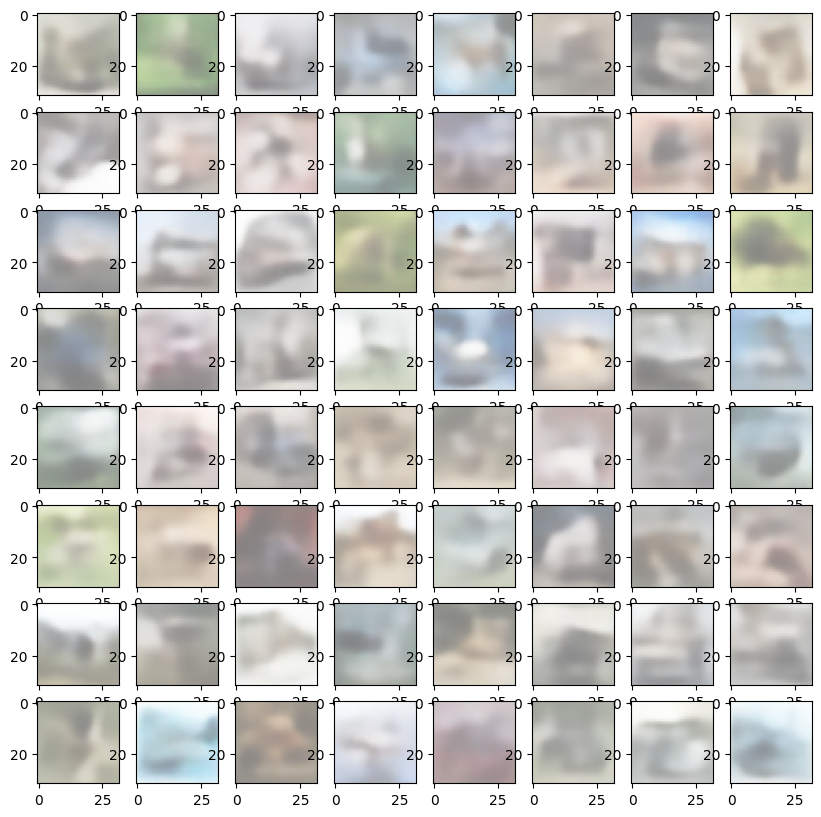

In [29]:
model.eval()
with torch.no_grad():
  z = torch.randn(64, 128).to(device)
  sample = model.decode(z).cpu()

def show_images(images):
  images = images.permute(0, 2, 3, 1).numpy()
  plt.figure(figsize=(10, 10))
  for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow((images[i] + 1) / 2)
  plt.show()

show_images(sample)

Train fully connected VAE

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = VAE(input_dim=3072, hidden_dim=512, latent_dim=128).to(device)
optimizer2 = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(50):
  model2.train()
  train_loss = 0
  for batch_idx, (data, _) in enumerate(train_loader):
    data = data.to(device).view(-1, 3072)
    optimizer2.zero_grad()
    recon_batch, mu, logvar = model2(data)
    loss = vae_loss(recon_batch, data, mu, logvar)
    loss.backward()
    train_loss += loss.item()
    optimizer2.step()

  print(f"Epoch {epoch+1}/{50}, Average_Loss: {train_loss/len(train_loader.dataset):.4f}")

Epoch 1/50, Average_Loss: 2133.4408
Epoch 2/50, Average_Loss: 2133.4316
Epoch 3/50, Average_Loss: 2133.4360
Epoch 4/50, Average_Loss: 2133.4347
Epoch 5/50, Average_Loss: 2133.4462
Epoch 6/50, Average_Loss: 2133.4422
Epoch 7/50, Average_Loss: 2133.4398
Epoch 8/50, Average_Loss: 2133.4357
Epoch 9/50, Average_Loss: 2133.4440
Epoch 10/50, Average_Loss: 2133.4342
Epoch 11/50, Average_Loss: 2133.4397
Epoch 12/50, Average_Loss: 2133.4296
Epoch 13/50, Average_Loss: 2133.4398
Epoch 14/50, Average_Loss: 2133.4512
Epoch 15/50, Average_Loss: 2133.4398
Epoch 16/50, Average_Loss: 2133.4430
Epoch 17/50, Average_Loss: 2133.4389
Epoch 18/50, Average_Loss: 2133.4342
Epoch 19/50, Average_Loss: 2133.4495
Epoch 20/50, Average_Loss: 2133.4367
Epoch 21/50, Average_Loss: 2133.4387
Epoch 22/50, Average_Loss: 2133.4450
Epoch 23/50, Average_Loss: 2133.4376
Epoch 24/50, Average_Loss: 2133.4316
Epoch 25/50, Average_Loss: 2133.4324
Epoch 26/50, Average_Loss: 2133.4415
Epoch 27/50, Average_Loss: 2133.4395
Epoch 28/5

Generate images(VAE)

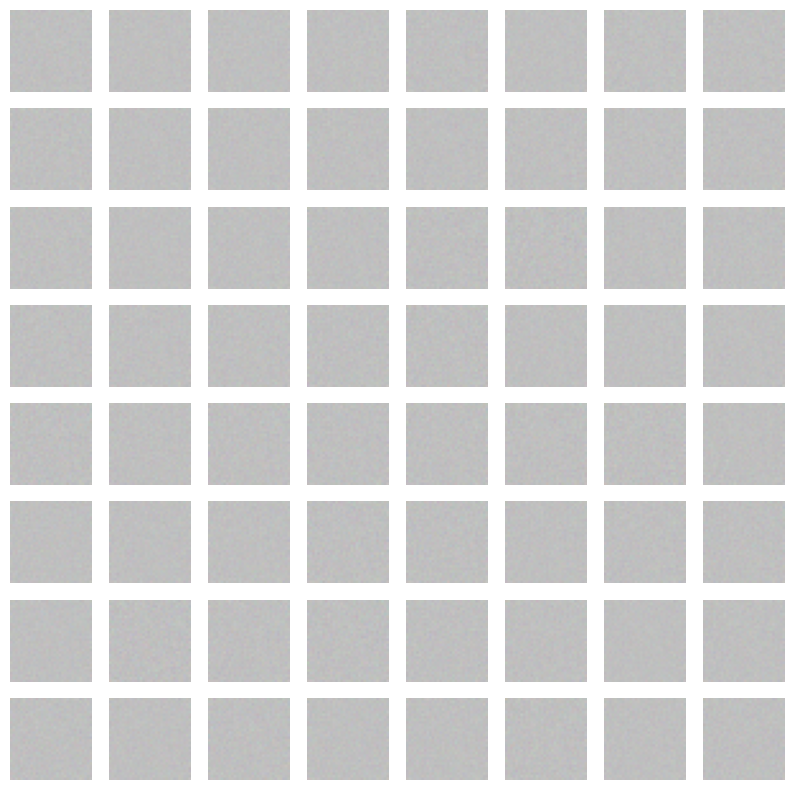

In [33]:
model2.eval()
with torch.no_grad():
  z = torch.randn(64, 128).to(device)
  sample2 = model2.decode(z).cpu()

def show_images(images):
  images = images.view(-1, 3, 32, 32).permute(0, 2, 3, 1).numpy()
  plt.figure(figsize=(10, 10))
  for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow((images[i] + 1) / 2)  # Rescale to [0, 1]
    plt.axis('off')
  plt.show()

show_images(sample2)

Task 2:

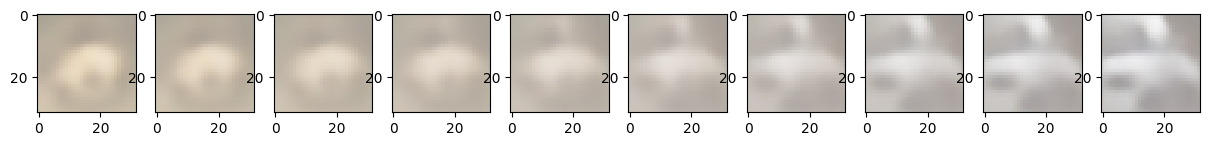

In [28]:
# Load two images
def select_images(dataset, index1, index2):
  img1, _ = dataset[index1]
  img2, _ = dataset[index2]
  return img1.unsqueeze(0), img2.unsqueeze(0)

img1, img2 = select_images(train_dataset, 0, 1)

# Encode
model.eval()
with torch.no_grad():
  img1 = img1.to(device)
  img2 = img2.to(device)
  mu1, logvar1 = model.encode(img1)
  mu2, logvar2 = model.encode(img2)
  z1 = model.reparameterize(mu1, logvar1)
  z2 = model.reparameterize(mu2, logvar2)

# Interpolate
def interpolate(z1, z2, num_steps=10):
  alpha = torch.linspace(0, 1, num_steps, device=device)
  lz = []
  for a in alpha:
    z = a * z2 + (1 - a) * z1
    lz.append(z)
  return torch.stack(lz)

num_steps = 10
lz = interpolate(z1, z2, num_steps)

# Decode
with torch.no_grad():
  interpolated_images = model.decode(lz).cpu()

def gen_images(images, num_steps):
  images = images.permute(0, 2, 3, 1).numpy()
  images = (images + 1) / 2
  plt.figure(figsize=(15, 2))
  for i in range(num_steps):
    plt.subplot(1, num_steps, i+1)
    plt.imshow(images[i])
  plt.show()

gen_images(interpolated_images, num_steps)

Task 3:

In [34]:
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# data loading
batch_size = 100
train_dataset = datasets.CelebA(root="./celeba", split='train', transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.usercontent.google.com/download?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=da36f124-ec23-4ba0-834e-66bc4b227200
To: /content/celeba/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:31<00:00, 45.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: /content/celeba/celeba/list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:00<00:00, 39.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS
To: /content/celeba/celeba/identity_CelebA.txt
100%|██████████| 3.42M/3.42M [00:00<00:00, 26.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pbThiMVRxWXZ4dU0
To: /content/celeba/celeba/list_bbox_celeba.txt
100%|██████████| 6.08M/6.08M [00:00<00:00, 38.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pd0FJY3Blby1HUTQ
To: /content/celeba/celeba/

In [38]:
class ConvVAE(nn.Module):
  def __init__(self, latent_dim=128):
    super(ConvVAE, self).__init__()
    self.latent_dim = latent_dim

    # Encoder
    self.encoder = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
      nn.ReLU(),
      nn.Flatten()
    )

    # Latent space
    self.fc_mu = nn.Linear(4096, latent_dim)
    self.fc_logvar = nn.Linear(4096, latent_dim)

    # Decoder
    self.decoder_fc = nn.Linear(latent_dim, 4096)
    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
      nn.ReLU(),
      nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
      nn.ReLU(),
      nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
      nn.ReLU(),
      nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
      nn.Tanh()
    )

  def encode(self, x):
    h = self.encoder(x)
    mu = self.fc_mu(h)
    logvar = self.fc_logvar(h)
    return mu, logvar

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def decode(self, z):
    h = self.decoder_fc(z)
    h = h.view(-1, 256, 4, 4)
    return self.decoder(h)

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar

In [40]:
def vae_loss(recon_x, x, mu, logvar):
  rl = F.mse_loss(recon_x, x, reduction='sum')  # Use MSE loss for CelebA
  kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return rl + kl

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvVAE(latent_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
  model.train()
  train_loss = 0
  for batch_idx, (data, _) in enumerate(train_loader):
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mu, logvar = model(data)
    loss = vae_loss(recon_batch, data, mu, logvar)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()

  print(f"Epoch {epoch+1}/{10}, Average_Loss: {train_loss/len(train_loader.dataset):.4f}")

Epoch 1/10, Average_Loss: 782.8236
Epoch 2/10, Average_Loss: 516.9735
Epoch 3/10, Average_Loss: 483.0257
Epoch 4/10, Average_Loss: 469.3274
Epoch 5/10, Average_Loss: 461.3989
Epoch 6/10, Average_Loss: 455.6417
Epoch 7/10, Average_Loss: 451.2714
Epoch 8/10, Average_Loss: 448.4507
Epoch 9/10, Average_Loss: 445.8385
Epoch 10/10, Average_Loss: 443.7752


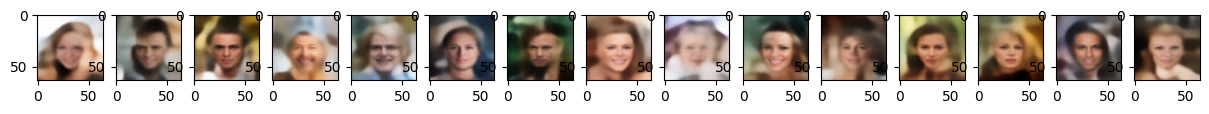

In [51]:
def generate_samples(model, num_samples=15):
  model.eval()
  with torch.no_grad():
    z = torch.randn(num_samples, model.latent_dim).to(device)
    samples = model.decode(z).cpu()
  return samples

def show_samples(samples):
  samples = samples.permute(0, 2, 3, 1).numpy()
  samples = (samples + 1) / 2
  plt.figure(figsize=(15, 3))
  for i in range(len(samples)):
    plt.subplot(1, len(samples), i+1)
    plt.imshow(samples[i])
  plt.show()

samples = generate_samples(model, num_samples=15)
show_samples(samples)

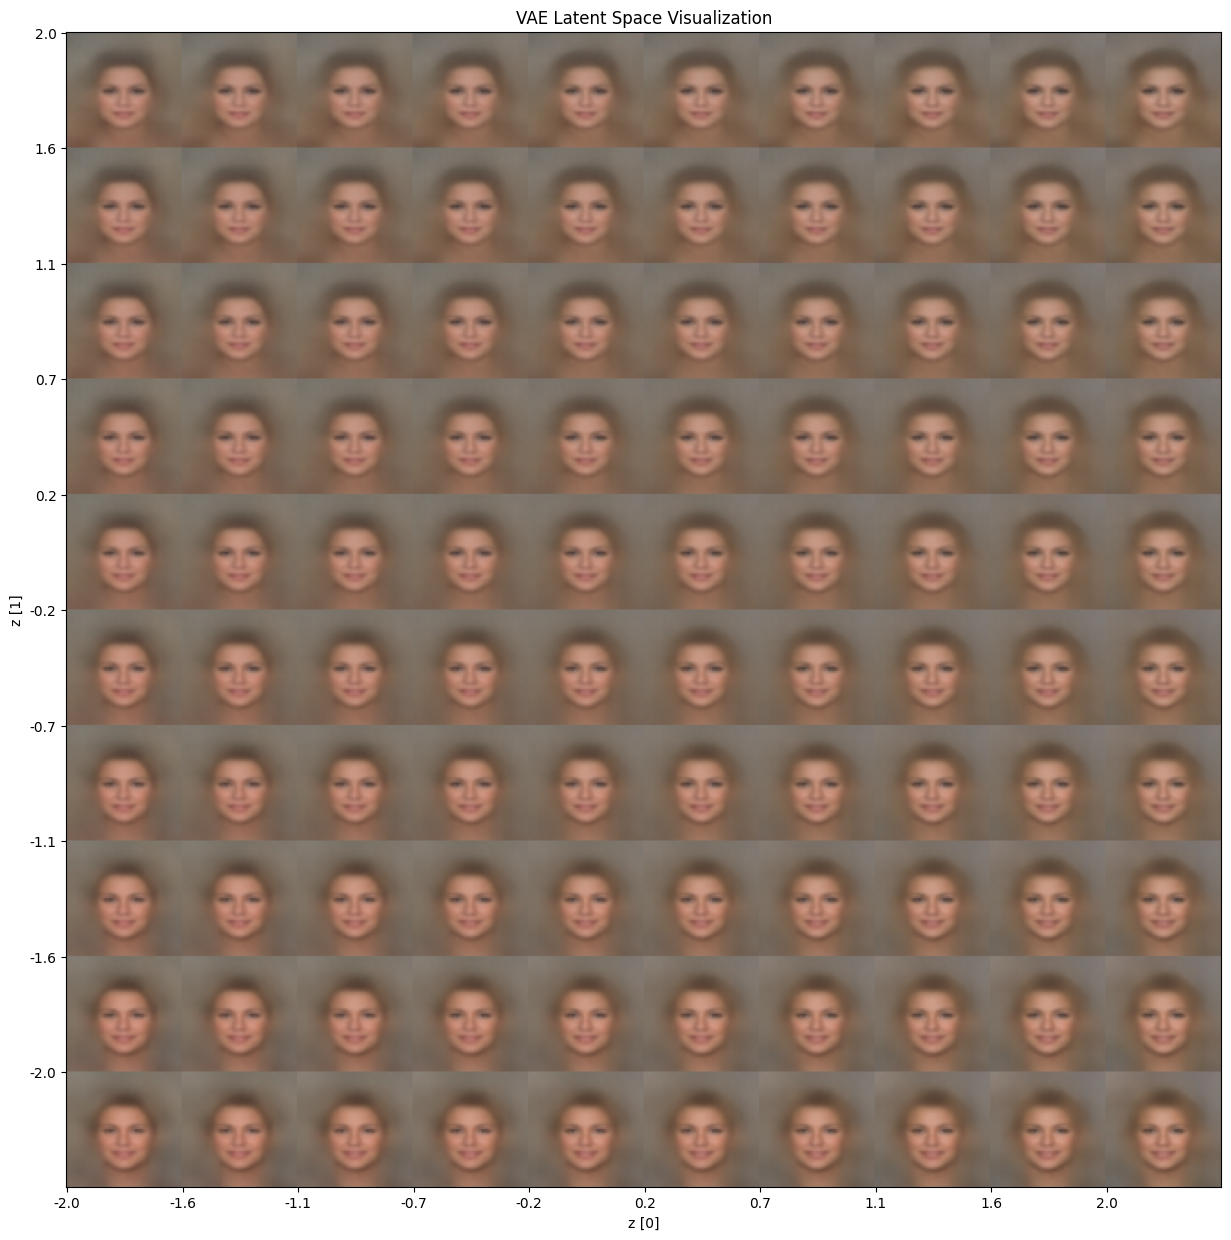

In [52]:
def plot_latent_space(model, scale=1.0, n=10, img_size=64, figsize=15):
  figure = np.zeros((img_size * n, img_size * n, 3))

  grid_x = np.linspace(-scale, scale, n)
  grid_y = np.linspace(-scale, scale, n)[::-1]

  for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
      z_sample = torch.zeros(1, model.latent_dim).to(device)
      z_sample[0, 0] = xi
      z_sample[0, 1] = yi

      with torch.no_grad():
        x_decoded = model.decode(z_sample).cpu()

      img = x_decoded[0].permute(1, 2, 0).numpy()
      img = (img + 1) / 2

      figure[ i * img_size : (i + 1) * img_size, j * img_size : (j + 1) * img_size, : ] = img

  plt.figure(figsize=(figsize, figsize))
  plt.title('VAE Latent Space Visualization')
  plt.imshow(figure)
  plt.xticks(np.arange(0, img_size * n, img_size), np.round(grid_x, 1))
  plt.yticks(np.arange(0, img_size * n, img_size), np.round(grid_y, 1))
  plt.xlabel("z [0]")
  plt.ylabel("z [1]")
  plt.show()

plot_latent_space(model, scale=2.0, n=10, img_size=64, figsize=15)

The latent space is continuous and smooth. With the different mean and variance, the model can generate image from the latent space.